# QA - 1
This file outlines the method for creating an **embedding based** question answering system.

In [1]:
from IPython.display import Image

In [2]:
import json
import numpy as np
import requests
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
import create_data_node as cdn
from utils import dbpedia_interface as dbi
from utils import query_graph_to_sparql as qgts
from utils import natural_language_utilities as nlutils

Traceback (most recent call last):
  File "/home/gaurav/codes/QA-Tutorial/utils/dbpedia_interface.py", line 137, in __init__
    self.labels = pickle.load(open('resources/labels.pickle'))
TypeError: a bytes-like object is required, not 'str'


Label Cache not found. Creating a new one
error. The relation file should have existed
check and continue
Loading Glove vocab and vectors from disk. Sit Tight.


# Goal

We want to get $\vec{q}$, and $\vec{c}$, and a method to compare $\vec{q}, \vec{c}$ getting a score.

We can use the score to select the _correct candidate_.

# Data Preparation
As discussed, we need a mechanism to generate core chain candidates given a question.
Following are the major steps followed
* Find the entity in the question
* Collect the subgraph around the entity
* Create a set of core chain candidates
* Rank the core chain candidates

### Entity linking

We employ [EARL](http://sda.cs.uni-bonn.de/projects/earl/) which returns a set of candidate entities of which we use the top most one. 

In [3]:
def get_entities(question,show_internals=False):
    """
        uses EARL to find all the entites present in the question.
        :param question: a natural language question.
        :return: entities list.
    """

    headers = {
        'Content-Type': 'application/json',
    }

    data = '{"nlquery":"%(p)s"}'% {"p":question}
    response = requests.post(' http://asknow02.sda.tech/earl/api/processQuery', headers=headers, data=data)
    a = json.loads(response.content)
    if show_internals:
        pprint(a)
    
    # Answer parsing
    entity_list = []
    for i in range(len(a['ertypes'])):
        if a['ertypes'][i] == 'entity':
            entity_list.append(a['rerankedlists'][str(i)][0][1]) # return the top most one. 
    return entity_list

print(get_entities('What are the awards won by Michael Crichton?',False))

['http://dbpedia.org/resource/Michael_Crichton']


### Sub Graph creation.

We follow a simple algorithm to generate a two hop sub graph.
* Step 1- Given an entity, find all outgoing and incoming relations and their corresponding 
* Step 2- Use the one-hopped entities and repeat Step 1 to collect a 2-hop subgraph

In [4]:
# Use this to execute SPARQL queries
dbp = dbi.DBPedia()
entity = 'http://dbpedia.org/resource/Michael_Crichton'

Label Cache not found. Creating a new one


Traceback (most recent call last):
  File "/home/gaurav/codes/QA-Tutorial/utils/dbpedia_interface.py", line 137, in __init__
    self.labels = pickle.load(open('resources/labels.pickle'))
TypeError: a bytes-like object is required, not 'str'


`SELECT DISTINCT ?property ?resource WHERE 
    { <%(target_resource)s> ?property ?resource }`

In [5]:
# To get the outgoing properties/relations and objects

# a) Create SPARQL
OUTGOING_SPARQL = \
            '''SELECT DISTINCT ?property ?resource WHERE { <%(target_resource)s> ?property ?resource}'''
sparql = OUTGOING_SPARQL % {'target_resource': entity}
print(sparql)

# b) Shoot the query to get answers
outgoing = dbp.shoot_custom_query(sparql)

SELECT DISTINCT ?property ?resource WHERE { <http://dbpedia.org/resource/Michael_Crichton> ?property ?resource}


In [6]:
# Parse the results
triples = []
for binding in outgoing['results']['bindings']:
    
    """ BLACKLISTING LOGIC GOES HERE """
    if not ( binding['property']['value'].startswith('http://dbpedia.org/') and
             binding['resource']['value'].startswith('http://dbpedia.org/') ):
        continue
    
    triple = [entity, binding['property']['value'], binding['resource']['value']]
    triples.append(triple)
    
pprint(triples[0])

['http://dbpedia.org/resource/Michael_Crichton',
 'http://dbpedia.org/property/influences',
 'http://dbpedia.org/resource/George_Orwell']


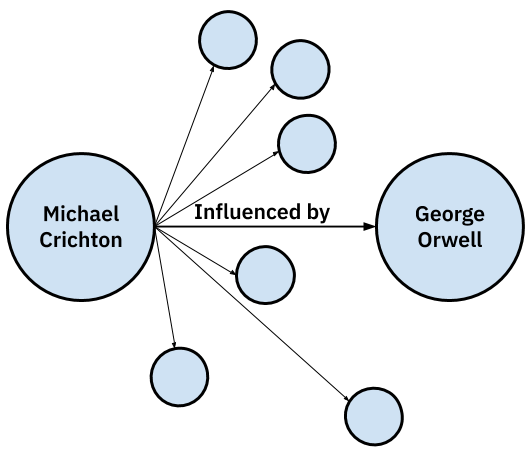

In [7]:
Image("img/outgoing.png")

#### Core Chains

`Michael Crichton -- (influenced by) --> George Orwell
 Michael Crichton -- (influenced by) --> POSSIBLE ANSWER
 Topic Entity     -- (influenced by) --> POSSIBLE ANSWER`

can be represented by 

`+ influenced by`

In [76]:
# Step for creating all incoming properties and object

# a) Create SPARQL
INCOMING_SPARQL = '''SELECT DISTINCT ?property ?resource WHERE { ?resource ?property <%(target_resource)s> }'''
sparql = INCOMING_SPARQL % {'target_resource':'http://dbpedia.org/resource/Michael_Crichton'}
print(sparql)

# b) Shoot the query to get answers
incoming = dbp.shoot_custom_query(sparql)

# c) Interpret results
incoming_triples = []
for binding in incoming['results']['bindings']:
    
    """ BLACKLISTING LOGIC GOES HERE """
    if not ( binding['property']['value'].startswith('http://dbpedia.org/') and
             binding['resource']['value'].startswith('http://dbpedia.org/') ):
        continue
    
    triple = [binding['resource']['value'], binding['property']['value'], entity]
    incoming_triples.append(triple)
    
pprint(incoming_triples[2])

SELECT DISTINCT ?property ?resource WHERE { ?resource ?property <http://dbpedia.org/resource/Michael_Crichton> }
['http://dbpedia.org/resource/ER_(season_1)',
 'http://dbpedia.org/property/writtenby',
 'http://dbpedia.org/resource/Michael_Crichton']


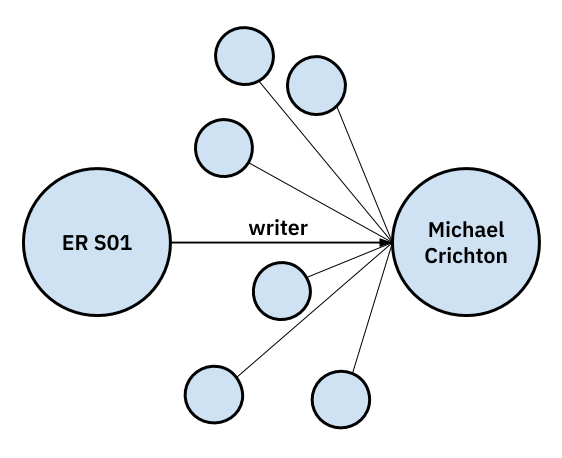

In [13]:
Image("img/incoming.png")

#### Core Chains

`ER S01          -- (writer) --> Michael Crichton
 POSSIBLE ANSWER -- (writer) --> Michael Crichton
 POSSIBLE ANSWER -- (writer) --> TOPIC ENTITY`

can be represented by 

`- writer`

#### Two hop Subgraph Candidates

In [14]:
triple = ['http://dbpedia.org/resource/Michael_Crichton', 
          'http://dbpedia.org/ontology/influences', 
          'http://dbpedia.org/resource/George_Orwell']

two_hop_triple = ['http://dbpedia.org/resource/George_Orwell',
                  'http://dbpedia.org/property/birthPlace',
                  'http://dbpedia.org/resource/Motihari']

# Combine them to form one path 
path = ' + influences + birthplace'

In [73]:
# Generalized Fn

pb = open('resources/predicate.blacklist').readlines()
pb[-1] = pb[-1] + '\n'
pb = [r[:-1] for r in pb]

cd_node = cdn.CreateDataNode(_predicate_blacklist=pb, _relation_file={}, _qald=False)
hop1,hop2  = cd_node.create_subgraph.subgraph\
            (['http://dbpedia.org/resource/Michael_Crichton'],[],_use_blacklist=True,_qald=False)

Label Cache not found. Creating a new one


Traceback (most recent call last):
  File "/home/gaurav/codes/QA-Tutorial/utils/dbpedia_interface.py", line 137, in __init__
    self.labels = pickle.load(open('resources/labels.pickle'))
TypeError: a bytes-like object is required, not 'str'


In [72]:
print('Few examples of hop1 candidates')
pprint(hop1[:5])
print('Few examples of hop2 candidates')
pprint(hop2[:5])

Few examples of hop1 candidates
[['-', 'http://dbpedia.org/ontology/notableStudent'],
 ['+', 'http://dbpedia.org/ontology/spouse'],
 ['+', 'http://dbpedia.org/ontology/education'],
 ['-', 'http://dbpedia.org/property/writer'],
 ['-', 'http://dbpedia.org/ontology/spouse']]
Few examples of hop2 candidates
[['+',
  'http://dbpedia.org/ontology/influencedBy',
  '-',
  'http://dbpedia.org/property/influences'],
 ['+',
  'http://dbpedia.org/ontology/birthPlace',
  '+',
  'http://dbpedia.org/property/bird'],
 ['+',
  'http://dbpedia.org/ontology/deathPlace',
  '+',
  'http://dbpedia.org/property/caption'],
 ['+',
  'http://dbpedia.org/property/influences',
  '-',
  'http://dbpedia.org/property/title'],
 ['+',
  'http://dbpedia.org/ontology/influencedBy',
  '-',
  'http://dbpedia.org/property/knownFor']]


#### Loading dataset. 

The dataset consists of 2000 questions without any rdf constraint or count or ask. It is just composed of single hop or two hop query.

In [17]:
# For brevity's sake, lets continue with this premade thing. Made by calling the fn above for some 2000 questions.
dataset = json.load(open('resources/dataset_with_paths.json'))

# Scoring Candidates

The general mechanism of these approaches involves two things

* a way to encode question and core chain candidates
* a way to compare these encoded representations

In other words

$ \text{answer} = \underset{c}{\text{argmax}}\ \big( \text{compare} (\text{encode}(q), \text{encode}(c)) \big)$

### Encode Function

We use pretrained word embeddings (for simplicity's sake) to do this.
Word embeddings can encode text in a multi-dimensional space where the dimensions capture some semantic meaning of the words.

![semantic space](img/embeddingspaces.png)
Image from https://docs.google.com/file/d/0B7XkCwpI5KDYRWRnd1RzWXQ2TWc/edit

We use GloVe vectors which can be found in `resources/glove.6B.300d.txt`
 

In [18]:
# Loading the GloVe file 
import numpy as np 

def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    
    # file open
    f = open(gloveFile,'r')
    vector_lookup = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        vector_lookup[word] = embedding
    
    print("Done.",len(vector_lookup)," words loaded!")
    return vector_lookup


glove = loadGloveModel('resources/glove.6B.300d.txt')

# Testing it 

print(glove['award'])

Loading Glove Model



Done. 400000  words loaded!
[ 0.44257    0.3437    -0.20689    0.33262   -0.32858    0.049876
 -0.81646   -0.089616  -0.63149   -0.58992    0.67766    0.014162
 -0.53956    0.52693    0.39746    0.23784   -0.12042    0.43829
  0.0076536 -0.72675    0.42447   -0.15929   -0.48648    0.21367
  0.064124  -0.31504   -0.013611   0.10138    0.55667   -0.040924
  0.37968   -0.28772   -0.037292   0.39581   -1.6416    -0.096931
  0.56206   -0.072841   0.28403    0.3204    -0.28404   -0.24488
  0.46817    1.0212    -0.3496     0.1294    -0.16042    0.24546
  0.059833  -0.3496    -0.2108    -0.096158   0.027446  -0.53761
  0.068201   0.50613   -0.46356   -0.23799   -0.19227   -0.33223
 -0.60071    0.13993    0.12347   -0.68083    0.3005     0.23952
 -0.024779   0.10946   -0.11747    0.28677    0.80632   -0.14015
  0.49855   -0.088363  -0.34722    0.13765    0.54237   -0.32921
  0.16036   -0.27565   -0.23412    0.085198   0.40191    0.29124
  0.16492   -0.13371   -0.34497   -0.43422   -0.32234   -

To encode question, 'What are the awards won by Michael Crichton ?', we will follow the folowing steps 

- **Step 1:** Tokenize question by splitting based on space (one cand use of the shelf tokenizer for significantly better performance)
- **Step 2:** Pass each token of the question through embedding matrix
- **Step 3:** Compute mean of all the words vectors of the question, to compute its final vector represenation

In [77]:
# Step 1
question = 'What are the awards won by Michael Crichton?'
question_tokens = question.split(' ')

In [78]:
# Step 2
question_token_vector = []
for qt in question_tokens:
    
    #lowercasing the token
    qt_lower = qt.lower()
    try:
        vec = glove[qt_lower]
    except KeyError:
        # Assign all unknown word a zero vector
        vec = np.zeros(300)
    
    question_token_vector.append(vec)

In [79]:
# Step 3
question_vector = np.mean(np.asarray(question_token_vector),axis=0)

#### Vectorizing Function

In [71]:
def encode(query):
    '''
        param: query - sentence/string to be encoded.
    '''
    query_token = query.split(' ')
    query_token_vector = []
    
    for qt in query_token:
        qt_lower = qt.lower()
        
        try:
            vec = glove[qt_lower]
        except KeyError:
            vec = np.zeros(300)
        
        query_token_vector.append(vec)
        
    v = np.mean(np.asarray(query_token_vector), axis=0)
    return v

#### Scoring function.

In [62]:
def compare(core_chain,question):
    '''
        potential code stub.
    '''
    if len(core_chain) == 2:
        # corechain looks like ['+', 'http:.../abc']
        predicate = nlutils.get_label_via_parsing(core_chain[1],lower=True)
    else:
        # corechain looks like ['+' 'http:../abc', '-', 'http:../pqr']
        predicate = [nlutils.get_label_via_parsing(core_chain[1],lower=True),
                     nlutils.get_label_via_parsing(core_chain[3],lower=True)]
        predicate = " ".join(predicate)
    
    question_vector = encode(query=question)
    predicate_vector = encode(query=predicate)
    
    if np.sum(question_vector) == 0.0 or np.sum(predicate_vector) == 0:
        return np.float64(0.0)
    else:
        return np.dot(predicate_vector, question_vector) / (np.linalg.norm(predicate_vector) *
                                                            np.linalg.norm(question_vector))
    
    # predicate is a string seperated by space -- 'abc pqr'
    

#### Evaluation

The code snippets for evaluating sparql with respect to ground truth sparql

In [63]:
def sparql_answer(sparql,dbi=None):
    '''
        Executes the sparql on dbpedia and returns answer as a list.
        :param sparql: SPARQL which will be executed.
        :param dbi: The dbpedia interface object which can be used for accesing dbpedia.
    '''
    if not dbi:
        dbi = dbp
    test_answer = []
    interface_test_answer = dbi.get_answer(sparql)
    for key in interface_test_answer:
        test_answer = test_answer + interface_test_answer[key]
    return list(set(test_answer))


def _evaluate_sparqls_(test_sparql, true_sparql,dbp):
    # @TODO: If the type of test and true are differnt code would return an error.
    """
        Fmeasure for ask and count are 0/1.
        Also assumes the variable to be always uri.
        :param test_sparql: SPARQL generated by the pipeline
        :param true_sparql: True SPARQL
        :param type: COUNT/ASK/LIST
        :return: f1,precision,recall
    """
    test_answer = sparql_answer(test_sparql,dbp)
    true_answer = sparql_answer(true_sparql,dbp)
    total_retrived_resutls = len(test_answer)
    total_relevant_resutls = len(true_answer)
    common_results = total_retrived_resutls - len(list(set(test_answer ) -set(true_answer)))
    if total_retrived_resutls == 0:
        precision = 0
    else:
        precision = common_results *1.0 /total_retrived_resutls
    if total_relevant_resutls == 0:
        recall = 0
    else:
        recall = common_results *1.0 /total_relevant_resutls
    if precision == 0 and recall == 0:
        f1 = 0
    else:
        f1 = (2.0 * (precision * recall)) / (precision + recall)
    return f1 ,precision ,recall

#### Putting it all together 

In [64]:
# Ranking
core_chain = dataset[0]['hop1'][1]
question = 'Who is the president of India ?'
compare(core_chain,question)


# Core chain to SPARQL
graph = {
    'best_path' : ['+', 'http://dbpedia.org/property/party', '+', 'http://dbpedia.org/ontology/ideology'],
    'entities' : ['http://dbpedia.org/resource/Michael_Crichton']
}
qgts.convert_runtime(graph)

'SELECT DISTINCT ?uri WHERE { {<http://dbpedia.org/resource/Michael_Crichton> <http://dbpedia.org/property/party> ?x} UNION {<http://dbpedia.org/resource/Michael_Crichton> <http://dbpedia.org/ontology/party> ?x} UNION {<http://dbpedia.org/resource/Michael_Crichton> <http://purl.org/dc/terms/party> ?x} . {?x <http://dbpedia.org/property/ideology> ?uri} UNION{?x <http://dbpedia.org/ontology/ideology> ?uri} UNION{?x <http://purl.org/dc/terms/ideology> ?uri} .  }'

In [80]:
dbp = dbi.DBPedia()
precision = []
f,p,r = [],[],[]

for node in tqdm(dataset[:10]):

    max_score = 0.0
    max_index = -1
    
    for index,cc in tqdm(enumerate([node['path']]+node['hop1']+node['hop2'])):

        # Find the score of the core chain
        score = compare(cc,node['node']['corrected_question'])

        # check if score is higher when compared to max_score and if so,
        # updated the max_score and index.
        if score > max_score:
            max_score = score
            max_index = index
    
    # if max_index is zero, it means the highest score was for the correct path.
    if max_index == 0:
        precision.append(1)
    else:
        precision.append(0)
    
    # find the highest scored path (corechain - cc.)
    combined = [node['path']]+node['hop1']+node['hop2']
    best_cc =  combined[max_index]
    
    # convert the highest scored cc to SPARQL.
    graph = {
        'best_path' : best_cc,
        'entities' : node['entity']
    }
    

    sparql = qgts.convert_runtime(graph)
    _f,_p,_r = _evaluate_sparqls_(test_sparql=sparql, true_sparql=node['node']['sparql_query'],dbp=dbp)
    
    f.append(_f)
    p.append(_p)
    r.append(_r)

Label Cache not found. Creating a new one


Traceback (most recent call last):
  File "/home/gaurav/codes/QA-Tutorial/utils/dbpedia_interface.py", line 137, in __init__
    self.labels = pickle.load(open('resources/labels.pickle'))
TypeError: a bytes-like object is required, not 'str'


In [81]:
np.mean(precision), np.mean(f), np.mean(p), np.mean(r)

(0.3, 0.33999999999999997, 0.4, 0.325)